<a href="https://colab.research.google.com/github/ducanhho2296/AI-Lab-Masked-Face-Recognition/blob/main/Test%20MFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet34- Face recognition [deepface](https://github.com/serengil/deepface)

github limit file size to upload model, so I upload the weights in google drive


In [ ]:
import gdown
!gdown 1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY

Downloading...
From: https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY
To: /content/arcface_weights.h5
100% 137M/137M [00:01<00:00, 83.5MB/s]


In [ ]:
!git clone https://github.com/kb22/Create-Face-Data-from-Images.git

Cloning into 'Create-Face-Data-from-Images'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (5/5), done.
remote: Total 24 (delta 4), reused 4 (delta 4), pack-reused 19
Unpacking objects: 100% (24/24), done.


##Model Arcface-Resnet34

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.engine import training

def ResNet34():

	img_input = layers.Input(shape=(112, 112, 3))

	x = layers.ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = layers.Conv2D(64, 3, strides=1, use_bias=False, 
                   kernel_initializer='glorot_normal', 
                   name='conv1_conv')(x)
	x = layers.BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)

	model = training.Model(img_input, x, name='ResNet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = layers.ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = layers.Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = layers.PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = layers.ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = layers.Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = layers.Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

###Load model

In [ ]:
def loadModel(model_path):
	base_model = ResNet34()
	inputs = base_model.inputs[0]
	arcface_model = base_model.outputs[0]
	arcface_model = layers.BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
	arcface_model = layers.Dropout(0.4)(arcface_model)
	arcface_model = layers.Flatten()(arcface_model)
	arcface_model = layers.Dense(512, activation=None, use_bias=True, kernel_initializer="glorot_normal")(arcface_model)
	embedding = layers.BatchNormalization(momentum=0.9, epsilon=2e-5, name="embedding", scale=True)(arcface_model)
	model = keras.models.Model(inputs, embedding, name=base_model.name)

	model.load_weights(model_path)

	return model

In [ ]:
model_path = "/content/arcface_weights.h5"
model = loadModel(model_path)

In [ ]:
model.summary() 
# tf.keras.utils.plot_model(model, to_file="demo.png", show_shapes=True)

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 114, 114, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  1728        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

##Testset-preprocessing

###Cosine distance

In [ ]:
#flag == 1: same person
#flag == 0: different person
#flag == 0.5: using LBP to recognize person

def findCosineDistance(source_representation, test_representation):
    flag = 0
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    dist = 1 - (a / (np.sqrt(b) * np.sqrt(c)))
    # print("cosine similarity: ", dist)
    #similarity threshold
    if dist >= 0 and dist < 0.3: flag = 1
    elif dist >= 0.3 and dist < 0.7: flag = 0.5
    else: flag = 0
    return flag

def findCosine_lite(a, b):
  a = np.array(a)
  b = np.array(b)
  dist = 1 - np.dot(a, b)
  return dist

###Loading image

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import base64
from pathlib import Path
from PIL import Image
import requests
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image as img_process

def load_image(img):
	exact_image = False; base64_img = False; url_img = False

	if type(img).__module__ == np.__name__:
		exact_image = True

	elif len(img) > 11 and img[0:11] == "data:image/":
		base64_img = True

	elif len(img) > 11 and img.startswith("http"):
		url_img = True

	#---------------------------

	if base64_img == True:
		img = loadBase64Img(img)

	elif url_img:
		img = np.array(Image.open(requests.get(img, stream=True).raw).convert('RGB'))

	elif exact_image != True: #image path passed as input
		if os.path.isfile(img) != True:
			raise ValueError("Confirm that ",img," exists")

		img = cv2.imread(img)

	return img


def preprocess_img(img, target_size=(112, 112), 
                   grayscale=False,
                   enforce_detection=True,
                   detector_backend='retinaface',
                   return_region=False,
                   align=True):
  img = load_image(img)
  base_img = img.copy()

  # img, region = detect_face(img = img,
  #                           detector_backend = detector_backend, 
  #                           grayscale = grayscale, 
  #                           enforce_detection = enforce_detection, 
  #                           align = align)

	#--------------------------

  if img.shape[0] == 0 or img.shape[1] == 0:
    if enforce_detection == True:
      raise ValueError("Detected face shape is ", img.shape,
                    ". Consider to set enforce_detection argument to False.")
    else: #restore base image
      img = base_img.copy()
#---------------------------------------------------------------

  #extract face from images
  (h, w) = img.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (112, 112)), 1.0, (112, 112), (104.0, 177.0, 123.0))
  protopath = "/content/Create-Face-Data-from-Images/model_data/deploy.prototxt"
  weightpath = "/content/Create-Face-Data-from-Images/model_data/weights.caffemodel"
  model = cv2.dnn.readNetFromCaffe(protopath, weightpath)

  model.setInput(blob)
  detections = model.forward()
  
  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, show box around face
    if (confidence > 0.5):
      cv2.rectangle(img, (startX, startY), (endX, endY), (255, 255, 255), 2)

  for i in range(0, detections.shape[2]):
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    confidence = detections[0, 0, i, 2]

    # If confidence > 0.5, save it as a separate file
    if (confidence > 0.5):
      img = img[startY:endY, startX:endX]
  frame = img.copy()
	#--------------------------

	#post-processing
  if grayscale == True:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	#---------------------------------------------------
	#resize image to expected shape


  if img.shape[0] > 0 and img.shape[1] > 0:
    factor_0 = target_size[0] / img.shape[0]
    factor_1 = target_size[1] / img.shape[1]
    factor = min(factor_0, factor_1)

    dsize = (int(img.shape[1] * factor), int(img.shape[0] * factor))
    img = cv2.resize(img, dsize)

    # Then pad the other side to the target size by adding black pixels
    diff_0 = target_size[0] - img.shape[0]
    diff_1 = target_size[1] - img.shape[1]
    if grayscale == False:
			# Put the base image in the middle of the padded image
      img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), 
                      (diff_1 // 2, diff_1 - diff_1 // 2), (0, 0)), 'constant')
    else:
      img = np.pad(img, ((diff_0 // 2, diff_0 - diff_0 // 2), 
                      (diff_1 // 2, diff_1 - diff_1 // 2)), 'constant')

	#------------------------------------------

	#double check: if target image is not still the same size with target.
  if img.shape[0:2] != target_size:
    img = cv2.resize(img, target_size)

	#---------------------------------------------------
	#normalizing the image pixels

  img_pixels = img_process.img_to_array(img) #what this line doing? must?
  img_pixels = np.expand_dims(img_pixels, axis = 0)
  img_pixels /= 255 #normalize input in [0, 1]

	#---------------------------------------------------

	# if return_region == True:
	# 	return img_pixels, region
	# else:
  return img_pixels, frame, base_img

def forward_image(img_path):
  
  img = preprocess_img(img_path, target_size=(112, 112))
  return img

Next: Create threshold Dmax = 0.35, if sim < Dmax => same person. If Dmax < sim < 0.7 => using LBP eyebrows. outside this bound will not be considered

##**Test model with test images**

In [ ]:
# img1_path = "/content/COMASK20/dataset/A_Testset/1/IMG_5288_120-with-mask.jpg"
# img2_path = "/content/COMASK20/dataset/A_Testset/10/Screenshot from 2020-07-09 11-10-06_nomask.png"


#####test load images with ImageDataGenerator()

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_data = datagen.flow_from_directory('/content/', target_size=(112,112))
# img_embedding = model.predict(test_data)
# img_embedding.shape

In [ ]:
# img1_embedding = model.predict(forward_image(img1_path))[0]
# img2_embedding = model.predict(forward_image(img2_path))[0]

In [ ]:
# sim = findCosineDistance(img1_embedding, img2_embedding)
# sim

####Plot images and do verifying task

In [ ]:
def plot_images(img1, img2, sentence=str):
  import matplotlib.pyplot as plt
  # img1 = plt.imread(img1_path)
  # img2 = plt.imread(img2_path)
  fig = plt.figure(figsize=(5, 5))
  rows = 2
  columns = 2
  
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(sentence)
    
  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)
    
  # showing image
  plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  # plt.title("Second")
  # Verify person with Cosine distance
  # dist_emb = findCosineDistance(img1_embedding, img2_embedding)
  

------------------------------------------------------------------------

_____________________________________________________________________________

##Local Binary Pattern

###Calculate LBP and Encode Image into LBP

In [ ]:
import cv2 
import numpy as np 

def calculate_LBP(img):
  # img = cv2.imread(img_path)
  def assign_bit(image, x, y, c):   #comparing bit with threshold value of centre pixel
      bit = 0  
      try:          
          if image[x][y] >= c: 
              bit = 1         
      except: 
          pass
      return bit 
  def local_bin_val(image, x, y):  #calculating local binary pattern value of a pixel
      eight_bit_binary = []
      centre = image[x][y] 
      powers = [1, 2, 4, 8, 16, 32, 64, 128] 
      decimal_val = 0
      #starting from top right,assigning bit to pixels clockwise 
      eight_bit_binary.append(assign_bit(image, x-1, y + 1,centre)) 
      eight_bit_binary.append(assign_bit(image, x, y + 1, centre)) 
      eight_bit_binary.append(assign_bit(image, x + 1, y + 1, centre)) 
      eight_bit_binary.append(assign_bit(image, x + 1, y, centre)) 
      eight_bit_binary.append(assign_bit(image, x + 1, y-1, centre)) 
      eight_bit_binary.append(assign_bit(image, x, y-1, centre)) 
      eight_bit_binary.append(assign_bit(image, x-1, y-1, centre)) 
      eight_bit_binary.append(assign_bit(image, x-1, y, centre))     
      #calculating decimal value of the 8-bit binary number
      for i in range(len(eight_bit_binary)): 
          decimal_val += eight_bit_binary[i] * powers[i] 
            
      return decimal_val 
  m, n, _ = img.shape 
  gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #converting image to grayscale
  lbp_img = np.zeros((m, n),np.uint8) 
  # converting image to lbp
  for i in range(0,m): 
      for j in range(0,n): 
          lbp_img[i, j] = local_bin_val(gray_scale, i, j) 
 
  n_bins1 = int(lbp_img.max() + 1)
  hist, _ = np.histogram(lbp_img, density=True, bins=n_bins1, range=(0, n_bins1))
  return hist, lbp_img

###Extract ROI using Dlib

In [ ]:
!git clone https://github.com/italojs/facial-landmarks-recognition

Cloning into 'facial-landmarks-recognition'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8
Unpacking objects: 100% (8/8), done.


In [ ]:
import imutils
from imutils import face_utils 
import dlib
import matplotlib.pyplot as plt
from collections import OrderedDict


def extract_ROI(img):
  face_detect = dlib.get_frontal_face_detector()
  landmark_detect = dlib.shape_predictor("/content/facial-landmarks-recognition/shape_predictor_68_face_landmarks.dat")


  FACIAL_LANDMARKS_IDXS = OrderedDict([("right_eyebrow", (17, 22)),
                                        ("left_eyebrow", (22, 27)),
                                        ("right_eye", (36, 42)),
                                        ("left_eye", (42, 48))])

  #-----------------------------------------------------------------------------#

  # from google.colab.patches import cv2_imshow

  roi_tuple = []
  clone_tuple = []
  face = face_detect(img, 1)
  # gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  for (i, rect) in enumerate(face):
    shape = landmark_detect(img, rect)
    shape = face_utils.shape_to_np(shape) #convert landmark (x,y) to array

    for (name, (i,j)) in FACIAL_LANDMARKS_IDXS.items():
      img_clone = img.copy()
      # cv2.putText(img_clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
      #             0.7, (0, 0, 255), 2)
      
      for (x, y) in shape[i:j]:
        cv2.circle(img_clone, (x, y), 3, (0, 255, 0), -1)
      (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
      roi = img[y:y + h, x:x + w]
      roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)
      roi_tuple.append(roi)
      clone_tuple.append(img_clone)

  ################################################################################
  #extract eye, eyebrow area histogram in LBP format
  if len(roi_tuple) != 0:
    hist0, img_lbp0 = calculate_LBP(roi_tuple[0])
    hist1, img_lbp1 = calculate_LBP(roi_tuple[1])
    hist2, img_lbp2 = calculate_LBP(roi_tuple[2])
    hist3, img_lbp3 = calculate_LBP(roi_tuple[3])

    #convert histogram in list 
    hist0 = list(hist0)
    hist1 = list(hist1)
    hist2 = list(hist2)
    hist3 = list(hist3)

    #concatenate histograms into a histogram
    hist = hist0 + hist1 + hist2 + hist3

  else: hist, img_lbp = calculate_LBP(img)
  
  return hist


##Test Algorithm with COMASK dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/comask20_testset"

load dataset

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_data = datagen.flow_from_directory('/content/COMASK20/dataset/A_Testset', target_size=(112,112))

In [ ]:
from imutils import paths
import numpy as np
import cv2
import os

# face_detect = dlib.get_frontal_face_detector()

def load_face_dataset(inputPath, minConfidence=0.5,
	minSamples=1):
	# grab the paths to all images in our input directory, extract
	# the name of the person (i.e., class label) from the directory
	# structure, and count the number of example images we have per
	# face
  imagePaths = list(paths.list_images(inputPath))
  # print(imagePaths)
  names = [p.split(os.path.sep)[-1] for p in imagePaths]
  (names, counts) = np.unique(names, return_counts=True)
  names = names.tolist()
  
  faces = [] 
  labels = []
  frames = []
  base_imgs = []
  for imagepath in imagePaths:
    image, frame, base_img = preprocess_img(imagepath, target_size=(112,112))
    name = imagepath.split(os.path.sep)[-1]
    # print(name)
    if counts[names.index(name)] < minSamples:
      continue
    faces.append(image)
    labels.append(name)
    frames.append(frame)
    base_imgs.append(base_img)

  faces = np.array(faces)
  labels= np.array(labels)

  return faces, labels, frames, base_imgs

In [ ]:
faces, labels, frames, base_imgs = load_face_dataset("/content/drive/MyDrive/Colab Notebooks/comask20_testset")

In [ ]:
len(frames)

101

###Extract facial Embeddings

In [ ]:
#emb0 = model.predict(faces)[0]
# emb1 = model.predict(faces[18])[0]
embeddings = []
flags = []
for i in faces:
  embedding = model.predict(i)[0]
  embeddings.append(embedding)


####Peform LBP to recognize faces, which can not be recognize by ResNet
*calculate histogram of all faces, and then calculate distance between each pairs, which were stored in the tuple: LBP_faces*



#####extract histogram of all faces (eye, eyebrow regions)


In [ ]:
labels[3]

'B17DCCN610-Nguyễn Văn Toàn-Masked03.jpg'

In [ ]:
labels[3].partition("-")[0]

'B17DCCN610'

In [ ]:
labels[3]

'B17DCCN610-Nguyễn Văn Toàn-Masked03.jpg'

In [ ]:
a = '/content/drive/MyDrive/Colab Notebooks/test/B15DCKT150/IMG_5288_135-with-mask.jpg'
c = '/content/drive/MyDrive/Colab Notebooks/test/B15DCKT150/B15DCKT150-NGUYEN-NGOC-SON-MASK02.jpg'
b = 'B15DCKT150'
c1 = a.partition(b)[-1]
c1

'/IMG_5288_135-with-mask.jpg'

In [ ]:
b not in c1

True

In [ ]:
hists = []
for face in frames:
  hist = extract_ROI(face)
  hists.append(hist)

In [ ]:
#store all cos_distance into a tuple 
#if cos = 1 and label1 == label2 => True Positive
#if cos = 0 and label1 != label2 => True negative
#if cos = 0.5, put these faces into a tuple, after that run KNN to choose min distance.

label_flags = []  #tuple of ground true, y_test
label_flag = 0    #ground true, 2 faces have the same label => label_flag = 1 
flags = []    #tuple of y_pred (after finding Cosine similarity)
LBP_flags = []      #tuple of faces, which will be classify by using LBP
LBP_labels =[] #store labels to use in LBP task

for i in range(len(embeddings)):
  hist_distances = []
  for j in range(len(embeddings) - 1, 0, -1):
    if i != j:
      flag = findCosineDistance(embeddings[i], embeddings[j])
      if flag != 0.5:
        flags.append(flag)

      elif flag == 0.5 and len(hists) != 0:
        if len(hists[i]) == len(hists[j]):
          dist = 1 - np.dot(hist[i], hist[j])
        else: dist = 10
        hist_distances.append(dist)

      #store labels for testing prediction  
      if labels[i].partition("-")[0] == labels[j].partition("-")[0] and flag != 0.5: 
        label_flag = 1
        label_flags.append(label_flag)
      elif labels[i].partition("-")[0] != labels[j].partition("-")[0] and flag != 0.5:
        label_flag = 0
        label_flags.append(label_flag)
      # else: print("this face must be verified by LBP")
      # label_flags.append(label_flag)
      # label_flag = 0

    else: continue  

#LBP prediction part
  if len(hist_distances) != 0:
    min_hist = min(hist_distances)
    min_index = hist_distances.index(min_hist)
    LBP_flags.append(1)
    if labels[min_index].partition("-")[0] == labels[min_index +1].partition("-")[0]: LBP_labels.append(1) #one hist have 2 faces, hist0 = dist(faces[0], faces[1])
    else: LBP_labels.append(0)

##Accuracy and ROC curve

###Accuracy without LBP method

accuracy without LBP is:  0.9642686233849099
F1 score without LBPis:  0.5371900826446281




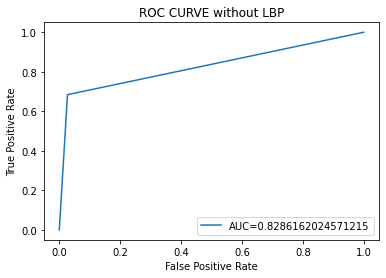

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# a = len([i for i, j in zip(flags, label_flags) if i == j])
# b = len(flags)
# acc = a/b *100
acc = accuracy_score(label_flags, flags)
print("accuracy without LBP is: ", acc)
print("F1 score without LBPis: ", f1_score(label_flags, flags))
print("\n")

fpr, tpr, _ = metrics.roc_curve(label_flags, flags)
auc = metrics.roc_auc_score(label_flags, flags)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("ROC CURVE without LBP")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

###Accuracy with LBP method

In [ ]:
total_flags = flags + LBP_flags
total_labels = label_flags + LBP_labels

accuracy with LBP is:  95.83987441130299
F1 score with LBP is:  0.5891472868217054




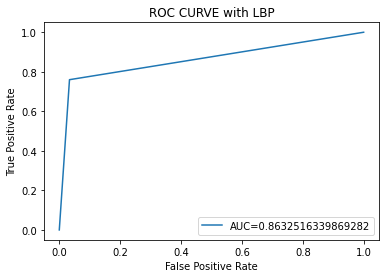

In [ ]:
a = len([i for i, j in zip(total_flags, total_labels) if i == j])
b = len(total_flags)
acc = a/b *100
print("accuracy with LBP is: ", acc)
print("F1 score with LBP is: ", f1_score(total_labels, total_flags))
print("\n")
fpr, tpr, _ = metrics.roc_curve(total_labels, total_flags)
auc = metrics.roc_auc_score(total_labels, total_flags)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title("ROC CURVE with LBP")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#Test with new Metric

In [ ]:
import os
import glob
import random
import time

random.seed(2468)

data_path = "/content/drive/MyDrive/Colab Notebooks/test/"

correct_predictions = 0
time_per_prediction = 0
start_total = time.time()
bad_predictions = []
num_prediction = 0
acc_per_sets = []

for dirname in os.listdir(data_path):
  genuine = [file for file in glob.glob(data_path + dirname + "/*")[0:6]]
  random.shuffle(genuine)
  imposter = random.sample([file for file in glob.glob(data_path + dirname + "/*")[6:]], 2)

  sets = [[imposter[0]] + genuine[0:3], [imposter[1]] + genuine[3:]]
  print("predicting {}".format(dirname))
  imposter = []
  faces = []
  embeddings = []
  acc_per_set = []
  for set in sets:
    faces = []
    for face in set:
      face, frame, base_img = preprocess_img(face, target_size=(112,112))
      faces.append(face)
    # for face in faces:
    #   embedding = model.predict(face)[0]
    #   embeddings.append(embedding)
    start_pred = time.time()
    # TODO add prediction here
    time_per_prediction += time.time() - start_pred
    for face in faces:
      embedding = model.predict(face)[0]
      embeddings.append(embedding)
    # face, frame, base_img = preprocess_img(set, target_size=(112,112))

    for i in range(len(embeddings)):
      for j in range(len(embeddings) - 1, 0, -1):
        if i != j:
          flag = findCosineDistance(embeddings[i], embeddings[j])
          if flag == 1 and set[i].partition("-")[0] == set[j].partition("-")[0]:
            correct_predictions += 1  # predicted same person and label return same person
            num_prediction += 1
          
          elif flag != 1 and set[i].partition("-")[0] != set[j].partition("-")[0]:
            correct_predictions += 1 #predicted not same person and label return not same person => imposter detected
            num_prediction += 1
          else: 
            if set not in bad_predictions:
              bad_predictions.append(set)
              num_prediction += 1  
      embeddings = []
    acc_per_set.append(correct_predictions / num_prediction)
    print("Accuracy per set:", correct_predictions / num_prediction)
  acc_per_set_mean = np.mean(acc_per_set)
acc_per_sets.append(acc_per_set_mean)
  # print("accuracy mean per sets", acc_per_set_mean)

    # TODO determine index of imposter and add to imposter list
    # if imposter[0] == 0:
    #     correct_predictions += 1
    # else:
    #     bad_predictions.append(sets[0])

    # if imposter[1] == 0:
    #     correct_predictions += 1
    # else:
    #     bad_predictions.append(sets[0])

    # print("Bad predictions: ", bad_predictions)

print("----------------------------------------")        
print("Total time: {}s\t Prediction time: {}s\t Mean prediction time per set: {}s".format(time.time() - start_total, 
                                                                                        time_per_prediction, time_per_prediction / (len(os.listdir(data_path)) * 2)))
print("----------------------------------------")        
print("total Accuracy of all Test Batches: ", np.mean(acc_per_sets))

In [4]:
import zipfile

!unzip /content/drive/MyDrive/Colab Notebooks/test/MLFWTestset.zip 
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/test/MLFWTestset.zip", 'r')
zip_ref.extractall("/content/Testset")
zip_ref.close()

unzip:  cannot find or open /content/drive/MyDrive/Colab, /content/drive/MyDrive/Colab.zip or /content/drive/MyDrive/Colab.ZIP.


In [ ]:
data_path = "/content/Testset/MLFWTestset/"

for dirname in os.listdir(data_path + "Genuine"):
  print("{}/{} Predicting {}".format(i+1, iterations, dirname))
  genuine_path = data_path + "Genuine" + "/" + dirname + "/*"
  imposter_path = data_path + "Imposter" + "/*"
  genuine = random.sample([file for file in glob.glob(genuine_path)], 3)
  imposter = random.sample([file for file in glob.glob(imposter_path)], 1)

  sets = [imposter + genuine]


print("Accuracy: ", correct_predictions / (len(os.listdir(data_path + "Genuine"))))
print("Total time: {}s\tPrediction time: {}s\tMean prediction time per set: {}s".format(time.time() - start_total, time_per_prediction, time_per_prediction / (len(os.listdir(data_path + "Genuine")))))

#another resnet34 model
This pretrained model came from insigntface, which required inputs as a tensor 

In [ ]:
!wget https://github.com/leondgarse/Keras_insightface/releases/download/v1.0.0/resnet34_MXNET_E_SGD_REG_1e3_on_batch_true_lr1e1_random0_arc_S32_E1_BS512_casia_basic_agedb_30_epoch_36_0.949500.h5

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model_34 = keras.models.load_model("resnet34_MXNET_E_SGD_REG_1e3_on_batch_true_lr1e1_random0_arc_S32_E1_BS512_casia_basic_agedb_30_epoch_36_0.949500.h5", compile=False)
model_34.summary()

In [ ]:
# validation_dir = "/content/test/"
# IMG_SIZE = (112, 112)
# BATCH_SIZE = 1
# validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
#                                                                  shuffle=False,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE)
#-----------------------------------------------------------------------------------------#
datagen = ImageDataGenerator(rescale=1.0/255.0)
test_data = datagen.flow_from_directory('/content/test', target_size=(112,112))

In [ ]:
emb = []
emb = model.predict(test_data)
# emb2 = model_34.predict(img2)

In [ ]:
import matplotlib.pyplot as plt
img1 = plt.imread("/content/test/0/14_resize.PNG")
img2 = plt.imread("/content/test/0/image_resize.jpg")
fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("Second")

# Verify person with Cosine distance
dist_emb_test = findCosineDistance(emb[0], emb[1])

#Convert to onnx model

In [ ]:
!pip install onnxruntime
!pip install onnx 

In [ ]:
import onnx 
import onnxruntime

model_onnx = onnx.load("/content/drive/MyDrive/Colab Notebooks/resnet/resnet34_ducanh.onnx")
outputs = []
for node in model_onnx.graph.node:
    print(node.name, node.input)
    outputs.extend(node.output)

# session = onnxruntime.InferenceSession("/content/resnet34.onnx")
# input = session.get_outputs()[0]
# print(input.shape)

In [ ]:
session = onnxruntime.InferenceSession("/content/drive/MyDrive/Colab Notebooks/resnet/resnet100.onnx")
input = session.get_inputs()[0]
print(input.shape)

freezing tf model and get graph node

In [ ]:
tf.saved_model.save(model, "/content/demo")

In [ ]:
%tensorflow_version 1.x

In [ ]:
import tensorflow as tf

def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

In [ ]:
export_path = '/content/demo/'

# We start a session using a temporary fresh Graph
with tf.Session(graph=tf.Graph()) as sess:
    '''
    You can provide 'tags' when saving a model,
    in my case I provided, 'serve' tag 
    '''

    tf.saved_model.loader.load(sess, ['serve'], export_path)
    graph = tf.get_default_graph()

    # print your graph's ops, if needed
    print(graph.get_operations())

    '''
    In my case, I named my input and output tensors as
    input:0 and output:0 respectively
    ''' 
    y_pred = sess.run('output:0', feed_dict={'input:0': X_test})

####Convert model Arcface to ONNX

In [ ]:
!pip install -U tf2onnx

In [ ]:
%tensorflow_version 2.x
!python -m tf2onnx.convert --saved-model /content/demo --output model_demo.onnx --inputs 'StatefulPartitionedCall/ResNet34/conv1_conv/Conv2D__6:0'['None',3,112,112]